# Note
This notebook is to train the encoder as a classifier with the idea of validate the encoder architecture first and then use this to train the VAE.

# Parameters to experiment

In [35]:
# training on guanaco
# ATENTION: if it is going to run on guanaco:
# 1) comment the %matplotlib magic in next block and any magic (something like %code)
# 2) Change to True the trainingOnGuanaco vairbale
# 3) set epoch with an appropiate number
# 4) add comment to experiemnts
# 5) Add this file as python file 
# 6) Change launchJobOnGuanaco file to run this file but with python format
trainingOnGuanaco = False

# train without notebook
trainWithJustPython = False

# number_experiment (this is just a name)
# priors:
# 1
number_experiment = 14
number_experiment = str(number_experiment)

# seed to generate same datasets
seed = 0

# training
epochs = 1000

# max elements by class
max_elements_per_class = 15000

# train with previous model
trainWithPreviousModel = False

# include delta errors
includeDeltaErrors = True

# band
# passband = [5]
passband = [0, 1, 2, 3, 4, 5]


# include ohter feautures
includeOtherFeatures = True

# num of features to add
# ṕvar by channel
otherFeaturesDim = 12

In [36]:
# cuda device
cuda_device = 0
cuda_device = "cuda:" + str(cuda_device)

# classes to analyze
# 42,  90,  16,  67,  62, 993,  92,  52,  88,  65, 991, 992,  15,
#        95,   6,  53, 994,  64

# periodic
# only_these_labels = [16, 92, 53]

# periodic + variable
only_these_labels = [16, 92, 53, 88, 65, 6]
# 53 has 24 light curves

# only_these_labels = [16, 92]
# only_these_labels = [16, 92]
# only_these_labels = [42,  90,  16,  67,  62, 993,  92,  52,  88,  65, 991, 992,  15,
#         95,   6,  53, 994,  64]

# VAE parameters
latentDim = 100
hiddenDim = 100
inputDim = 72

batch_training_size = 128

# early stopping 
threshold_early_stop = 3000

In [37]:
# training params
learning_rate = 1e-3

In [38]:
# add general comment about experiment 
# comment = "encoder as clasifier with periodic + variable (with class balancing) + 1 conv layer more"
comment = "exp " + number_experiment + " + encoder as clasifier with periodic + variable + class balancing + 1 conv layer more + " + str(len(passband)) + " channels + seed " + str(seed) + " + " + ("include delta errors" if includeDeltaErrors else "without delta errors") + " + max by class " + str(max_elements_per_class) + " + " + ("" if includeOtherFeatures else "not") + " other features"

print(comment)

exp 14 + encoder as clasifier with periodic + variable + class balancing + 1 conv layer more + 6 channels + seed 0 + include delta errors + max by class 15000 +  other features


# Import libraries

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.utils import data

# from tqdm import tqdm_notebook

# %matplotlib notebook

# import functions to load dataset
import sys
sys.path.append("./codesToDatasets")
from plasticc_dataset_torch import get_plasticc_datasets
# from plasticc_plotting import plot_light_curve

import math

from torch import nn

# local imports
# %load_ext autoreload
# %autoreload 2
sys.path.append('../models')
# from classifier import EncoderClassifier, 
from classifierPrototype import EncoderClassifier

sys.path.append("./aux/")
from auxFunctions import *

from sklearn.model_selection import train_test_split

## Load the path to save model while training

In [53]:
import os

# create experiment's folder
tmpGuanaco = "/home/lbravo/thesis/thesis/work/thesis/"
tmpLocal = "/home/leo/Desktop/thesis/work/thesis/"

expPath = "experiments/" + number_experiment + "/seed" + str(seed) + "/maxClass" + str(int(max_elements_per_class/1000)) + "k"

folder_path = (tmpGuanaco + expPath) if trainingOnGuanaco else (tmpLocal + expPath)
# !mkdir folder_path
# os.makedirs(os.path.dirname(folder_path), exist_ok=True)

# check if folder exists
if not(os.path.isdir(folder_path)):
        
    # create folder
    try:
        os.makedirs(folder_path)
        
    except OSError as error:
        print ("Creation of the directory %s failed" % folder_path)
        print(error)
    else:
        print ("Successfully created the directory %s " % folder_path)
else:
    print("folder already exists")

# define paht to save model while training
pathToSaveModel = (tmpGuanaco + expPath + "/model") if trainingOnGuanaco else (tmpLocal + expPath + "/model")

folder already exists


# Load data

In [54]:
# define path to dataset
pathToFile = "/home/shared/astro/PLAsTiCC/" if trainingOnGuanaco else "/home/leo/Downloads/plasticData/"

## Loading dataset with pytorch tool

In [55]:
# torch_dataset_lazy = get_plasticc_datasets(pathToFile)

# Light curves are tensors are now [bands, [mjd, flux, err, mask],
# lc_data, lc_label, lc_plasticc_id                              
torch_dataset_lazy = get_plasticc_datasets(pathToFile, only_these_labels=only_these_labels, max_elements_per_class = max_elements_per_class)

You have selected lazy loading. Light curves will be loaded ondemand from the harddrive
Found 2 csv files at given path
Loading /home/leo/Downloads/plasticData/plasticc_train_lightcurves.csv
Loading /home/leo/Downloads/plasticData/plasticc_test_set_batch1.csv


In [56]:
assert torch_dataset_lazy.__len__() != 494096, "dataset should be smaller"
print("dataset test ok")

dataset test ok


# Spliting data (train/test)

In [57]:
# splitting the data

# get light curves ids, targets
ids, targets, lightCurvesIds = getLightCurvesIds(torch_dataset_lazy)

# test array shapes
# assert len(targets) == torch_dataset_lazy.__len__()
# print(ids, len(ids), targets, len(targets))
# get light curves targets
print("# light curves ids: " + str(len(ids)))

# split training
trainIdx, tmpIdx = train_test_split(
    ids,
    test_size = 0.2,
    shuffle = True,
    stratify = targets,
    random_state = seed
)

# float to int
tmpIdx = tmpIdx.astype(int)

# split val, test
valIdx, testIdx = train_test_split(
    tmpIdx,
#     targets,
    test_size = 0.5,
    shuffle = True,
    stratify = targets[tmpIdx],
    random_state = seed
)

# float to int
trainIdx = trainIdx.astype(int)
valIdx = valIdx.astype(int)
testIdx = testIdx.astype(int)

# light curves ids: 3276


In [58]:
# # saving ids
# saveLightCurvesIdsBeforeBalancing(trainIdx, valIdx, testIdx, folder_path, lightCurvesIds, targets)

In [59]:
# # load ids dictionary
# a_file = open(folder_path + "/dataset_ids_before_balancing.pkl", "rb")
# output = pickle.load(a_file)
# print(output)

(array([ 16.,  93.,   0.,   0.,   0.,   4., 104.,   0.,   0., 111.]),
 array([ 6. , 14.6, 23.2, 31.8, 40.4, 49. , 57.6, 66.2, 74.8, 83.4, 92. ]),
 <BarContainer object of 10 artists>)

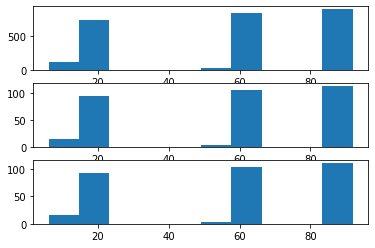

In [60]:
# # analize classes distributino
fig, ax = plt.subplots(3, 1)

ax[0].hist(targets[trainIdx])
ax[1].hist(targets[valIdx])
ax[2].hist(targets[testIdx])

In [61]:
# # Spliting the data

# # print(torch_dataset_lazy.__len__())

totalSize = torch_dataset_lazy.__len__()

# totalSize = totalSize
# # print(totalSize)

# selecting train splitting
# train_size = int(0.8 * totalSize)
train_size = trainIdx.shape[0]
#print(train_size)

# # getting test splitting
# validation_size = math.floor((totalSize - train_size)/3)
validation_size = valIdx.shape[0]
# #print(validation_size)

# # getting test splitting
# test_size = totalSize - train_size - validation_size
test_size = testIdx.shape[0]
# #print(test_size)

# # spliting the torch dataset
# trainDataset, validationDataset,  testDataset = torch.utils.data.random_split(
#     torch_dataset_lazy, 
#     [train_size, validation_size, test_size],
    
#     # set seed
#     generator = torch.Generator().manual_seed(seed)
# )

print("train size:", train_size)
print("validation size: ", validation_size)
print("test size:", test_size)
totTmp = train_size+ validation_size + test_size
print("sum: ", totTmp)
assert torch_dataset_lazy.__len__() == totTmp, "dataset partition should be the same"

train size: 2620
validation size:  328
test size: 328
sum:  3276


## Create a dataloader

In [62]:
print("initila distribution")
# initialClassesDistribution = countClasses(trainDataset, only_these_labels)
initialClassesDistribution = np.unique(targets, return_counts=True)[1]

print(initialClassesDistribution)

# fig, ax = plt.subplots()
# ax.bar(x = np.arange(len(only_these_labels)), height = initialClassesDistribution)

initila distribution
[ 157  927   36 1042  733  381]


In [63]:
# # Create data loader (minibatches)

# training loader
trainLoader = torch.utils.data.DataLoader(
    torch_dataset_lazy, 
    batch_size = batch_training_size, 
    # to balance classes
    sampler=ImbalancedDatasetSampler(
        torch_dataset_lazy, 
        indices = trainIdx,
        seed = seed
#         indices = [0, 1, 2]
    ),
    # each worker retrieve data from disk, so the data will be ready to be processed by main process. The main process should get the data from disk, so if workers > 0, the workers will get the data (not the main process)
    num_workers = 4,
    
    # https://developer.nvidia.com/blog/how-optimize-data-transfers-cuda-cc/
    # the dataloader loads the data in pinned memory (instead of pageable memory), avoiding one process (to transfer data from pageable memory to pinned memory, work done by CUDA driver)
    pin_memory = True,
)


# validation loader
validationLoader = torch.utils.data.DataLoader(
#     validationDataset, 
    torch_dataset_lazy,
    batch_size= batch_training_size,  
    num_workers = 4,
    pin_memory = True,
    sampler = torch.utils.data.SubsetRandomSampler(
        valIdx,
        generator = torch.Generator().manual_seed(seed)
    ),
)

# # test loader
# testLoader = torch.utils.data.DataLoader(testDataset)
testLoader = torch.utils.data.DataLoader(
#     validationDataset, 
    torch_dataset_lazy,
#     batch_size= batch_training_size,  
    num_workers = 4,
    pin_memory = True,
    sampler = torch.utils.data.SubsetRandomSampler(
        testIdx,
        generator = torch.Generator().manual_seed(seed)
    ),
)

In [64]:
print("balanced distribution")
balancedClassesDistribution = countClasses(trainLoader, only_these_labels)

print(balancedClassesDistribution)
# fig, ax = plt.subplots()
# ax.bar(x = np.ar# return 0# return 0ange(6), height = balancedClassesDistribution)
# ax.bar(x = only_these_labels, height = temp2, width = 10)

balanced distribution
[444. 420. 439. 474. 400. 443.]


## Defining parameters to Autoencoder

In [65]:
# check number of parameters
# latentDim = 5
# hiddenDim = 10
# inputDim = 72

latentDim = latentDim
hiddenDim = hiddenDim
inputDim = inputDim

# passband = passband

num_classes = len(only_these_labels)

if trainWithPreviousModel:
    
    # loadgin model
    model = torch.load(pathToSaveModel + ".txt").to(device = cuda_device)
    
    print("loading saved model")
    
else:
    
    # defining model
    model = EncoderClassifier(
        latent_dim = latentDim, 
        hidden_dim = hiddenDim, 
        input_dim = inputDim, 
        num_classes = num_classes, 
        passband = passband, 
        includeDeltaErrors = includeDeltaErrors,
        includeOtherFeatures = includeOtherFeatures,
        otherFeaturesDim = otherFeaturesDim,
    )

    # mdel to GPU
    model = model.to(device = cuda_device)
    
    print("creating model with default parameters")

creating model with default parameters


In [66]:
print(model)

EncoderClassifier(
  (pconv1): PartialConv(
    (input_conv): Conv1d(6, 64, kernel_size=(3,), stride=(2,))
    (mask_conv): Conv1d(6, 64, kernel_size=(3,), stride=(2,), bias=False)
  )
  (pconv2): PartialConv(
    (input_conv): Conv1d(64, 32, kernel_size=(3,), stride=(2,))
    (mask_conv): Conv1d(64, 32, kernel_size=(3,), stride=(2,), bias=False)
  )
  (pconv3): PartialConv(
    (input_conv): Conv1d(32, 32, kernel_size=(3,), stride=(2,))
    (mask_conv): Conv1d(32, 32, kernel_size=(3,), stride=(2,), bias=False)
  )
  (hidden1): Linear(in_features=780, out_features=100, bias=True)
  (outputLayer): Linear(in_features=100, out_features=6, bias=True)
  (activationConv): ReLU()
  (activationLinear): ReLU()
)


### Training

In [93]:
from sklearn.metrics import f1_score

# optimizeraa
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.5)

# loss function
lossFunction = nn.CrossEntropyLoss()

# loss
train_loss = np.zeros((epochs,))
test_loss = np.zeros((epochs,))

# f1 scores
f1Scores = np.zeros((epochs, ))

# min global test loss 
minTestLossGlobalSoFar = float("inf")


# early stopping
# prior_test_error = 0
count_early_stop = 0
threshold_early_stop = threshold_early_stop


# save features
otherFeaturesArray = np.zeros(shape = (train_size, otherFeaturesDim))

print("starting the training")


    
lastIndex = 0

for data_ in trainLoader:

    data = data_[0]
    labels = data_[1].to(device = cuda_device)
#         labels = data_[1]

    optimizer.zero_grad()

    # this take the deltas (time and magnitude)
    data = generateDeltas(data, passband, includeDeltaErrors).type(torch.FloatTensor).to(device = cuda_device)
#         data = generateDeltas(data, passband).type(torch.FloatTensor)

    # add other features
    # [batch size, features]
#         if includeOtherFeatures:
    if includeOtherFeatures:

        otherFeatures = getOtherFeatures(data_[0]).to(device = cuda_device)
        
#         print(np.any(otherFeatures[:, 6:].cpu().numpy() < 0 ))
        
        if np.any(otherFeatures[:, 6:].cpu().numpy() < 0):
            print("negative values")
            
        lastIndex_ = lastIndex + data_[0].shape[0]
        
        otherFeaturesArray[lastIndex : lastIndex_] = otherFeatures.cpu().numpy()
        
        lastIndex = lastIndex_
        
print("finish")

starting the training
finish


In [94]:
otherFeaturesArray.shape

(2620, 12)

# Save file

In [21]:
# # save array
# a_file = open("./otherFeaturesValues.pkl", "wb")
# pickle.dump(otherFeaturesArray, a_file)
# a_file.close()

### Stop execution if it's on cluster

In [22]:
import sys

if  trainingOnGuanaco or trainWithJustPython:

    sys.exit("Exit from code, because we are in cluster or running locally. Training has finished.")

# Load

In [73]:
# load
a_file = open("./otherFeaturesValues.pkl", "rb")
otherFeaturesArray = pickle.load(a_file)

In [74]:
otherFeaturesArray.shape

(52360, 12)

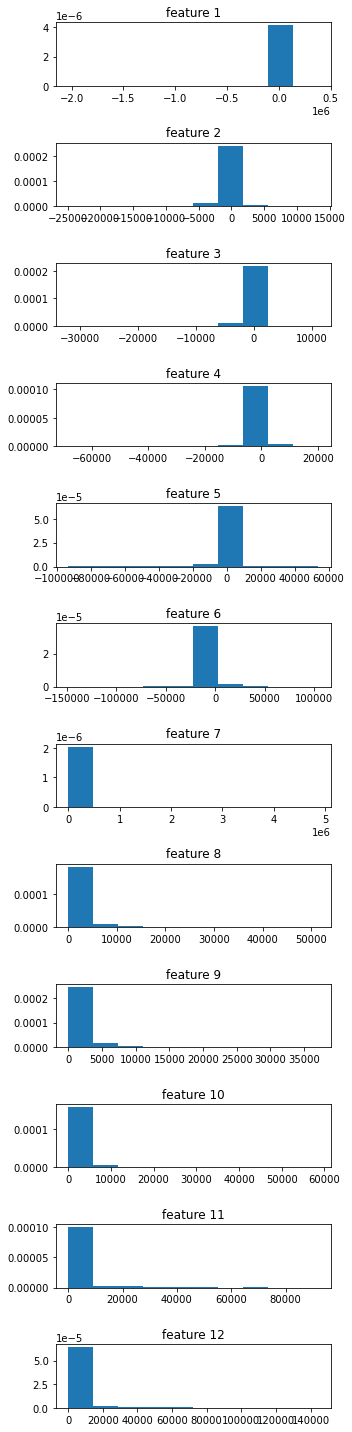

In [76]:
# assert (train_size, otherFeaturesDim) == otherFeaturesArray.shape

fig, ax = plt.subplots(otherFeaturesDim, 1, figsize = (5, 20), tight_layout = True)

for i in np.arange(otherFeaturesDim):
    
    ax[i].hist(otherFeaturesArray[:, i], density = True)
    ax[i].set_title(f"feature {i+1}")

# Plot features

In [99]:
otherFeatures.shape

torch.Size([60, 12])

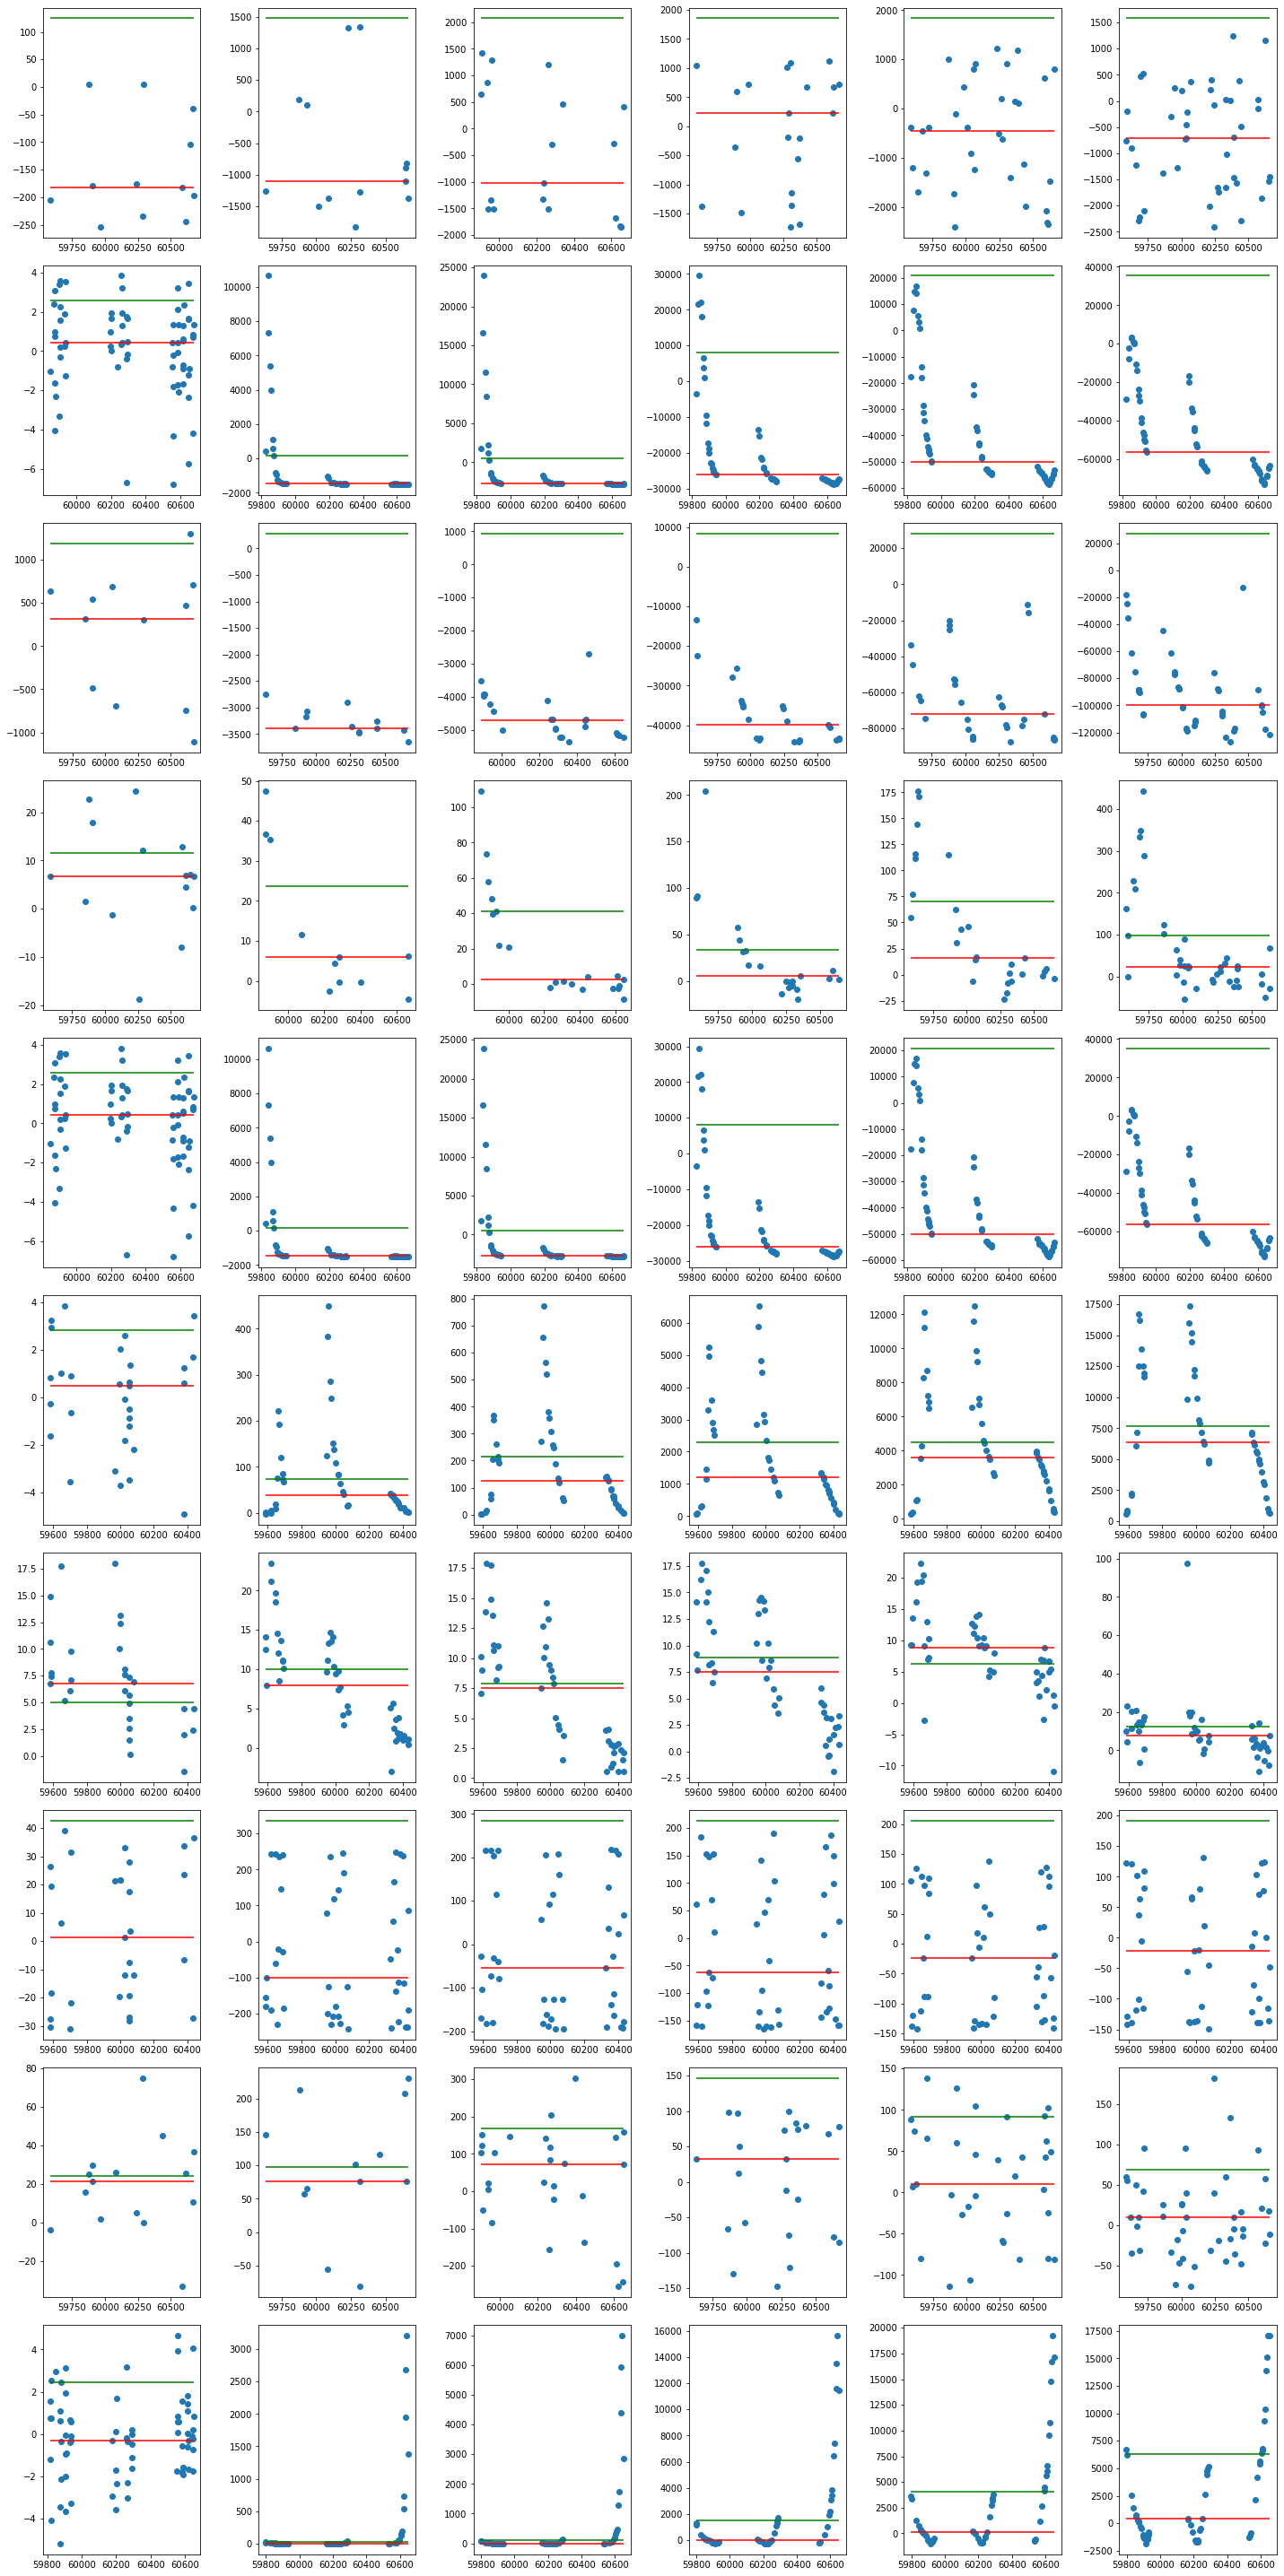

In [112]:
# testing if means and iq are correct

channels = [0, 1, 2, 3, 4, 5]
indexs = np.random.choice(len(data_[2]), 10)

# print(indexs)

fig, ax = plt.subplots(
    len(indexs), 
    len(channels),
    figsize = (20, 4*len(indexs)),
    tight_layout = True,
)

for index in np.arange(len(indexs)):
    
    for channel in channels:
    
        mask = data_[0][indexs[index], channel, 3, :]

        mask = mask.type(torch.BoolTensor)
    
#         print(f"index: {indexs[index]}")
        
        # print("data shape")
        # print(data_[0].shape)

        # datashape: [ 128, 6, 4, 72 ]
        ax[index][channel].scatter(
            data_[0][indexs[index], channel, 0, mask], 
            data_[0][indexs[index], channel, 1, mask],
        )

        # print("values:")
        # print(otherFeatures[index, 0])


#         # manual mean
#         manualMean = torch.mean(data_[0][indexs[index], channel, 1, mask])

#         ax[index][channel].hlines(
#             manualMean, 
#             xmin = data_[0][indexs[index], channel, 0, mask][0], 
#             xmax = data_[0][indexs[index], channel, 0, mask][-1],
#             color = "r"
#         )
        
        # analyze features
        # means
        ax[index][channel].hlines(
            otherFeatures[indexs[index], channel].item(), 
            xmin = data_[0][indexs[index], channel, 0, mask][0], 
            xmax = data_[0][indexs[index], channel, 0, mask][-1],
            color = "r"
        )
        
#         analyze features
# #         iq
        ax[index][channel].hlines(
            otherFeatures[indexs[index], channel + 6].item(), 
            xmin = data_[0][indexs[index], channel, 0, mask][0], 
            xmax = data_[0][indexs[index], channel, 0, mask][-1],
            color = "g"
        )
        
#         # test mean
#         assert manualMean.item() == otherFeatures[indexs[index], channel].item()
#         print("mean test ok")

        
#         iqManual =  torch.kthvalue(data_[0][indexs[index], channel, 1, mask], int(0.75*data_[0][indexs[index], channel, 1, mask].shape[0]))[0] - torch.kthvalue(data_[0][indexs[index], channel, 1, mask], int(0.25*data_[0][indexs[index], channel, 1, mask].shape[0]))[0]

#         assert iqManual.item() == otherFeatures[indexs[index], 6 + channel].item()
#         print("iq test ok")
        
        
#         print(manualMean.item())
#         print(otherFeatures[indexs[index], channel].item())
#         print("----")

# Check other features values

In [71]:
np.any(np.isnan(otherFeaturesArray))

False

In [70]:
np.any(otherFeaturesArray[:, 6:] < 0)

False